# 앙상블 학습과 랜덤 포레스트
### 앙상블 학습(Ensemble Learning)
- 일련의 여러 개(SVM, 결정트리 등)의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음

### 랜덤 포레스트(Random Forest)
- 결정 트리의 앙상블
- 예측을 하려면 모든 개별 트리의 예측을 구한 후, 가장 많은 선택을 받은 클래스를 예측으로 삼음

# 7.1 투표 기반 분류기
### 직접 투표 분류기
- 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측
- 다수결 투표로 정해지는 분류기
- 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음

### 간접 투표 분류기
- 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 **평균**내어 확률이 가장 높은 클래스를 예측할 수 있음
- 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표방식보다 성능이 높음

### Moon dataset
- make_moons(): 분산이 0.3인 가우시안 노이즈를 추가한 500개의 샘플 데이터 생성
- random_state(): 데이터 shuffle 시 사용되는 초기 값, 반복 연산시에 동일한 결과를 생성할 수 있도록 함

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)      #데이터 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)     #Train, test 데이터 분류

### Logistic Regression, Random Forest, SVM 직접투표 분류기
- LogisticRegression()
 - solver:Algorithm to use in the optimization problem('lbfgs'for multiclass problems)
- RandomForestClassifier()
 - n_estimators: number of trees in the forest
- SCV()
 - gamma: kerner codfficient for 'rbf', 'poly' and 'sigmoid', 하나의 훈련 샘플에 미치는 영향의 범위를 결정
 - gamma='scale': uses 1/(n_features * X.var()) as value of gamma

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),('svc', svm_clf)],
    voting='hard'
)

In [5]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

### 각 분류기 성능 확인

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### Logistic Regresssion, Random Forest, SVM과 간접투표 기반 분류기

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True)    #SVC의 기본값에서는 클래스 확률을 제공X 

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),('svc', svm_clf)],
    voting='soft'
)

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅과 페이스팅
- 배깅(bagging, bootstrap aggregating): 훈련 세트에 중복을 허용하여 샘플링하는 방식
- 페이스팅(pasting): 훈련 세트에 중복을 허용하지 않고 샘플링하는 방식

### 다양한 분류기 만드는 방법
- 각기 다른 훈련 알고리즘을 사용함
- 각기 다른 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킴

### 앙상블 예측이 결정 트리 하나의 예측보다 일반화가 잘됨
- 비슷한 편향에서 더 작은 분산을 만듦
- 훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함

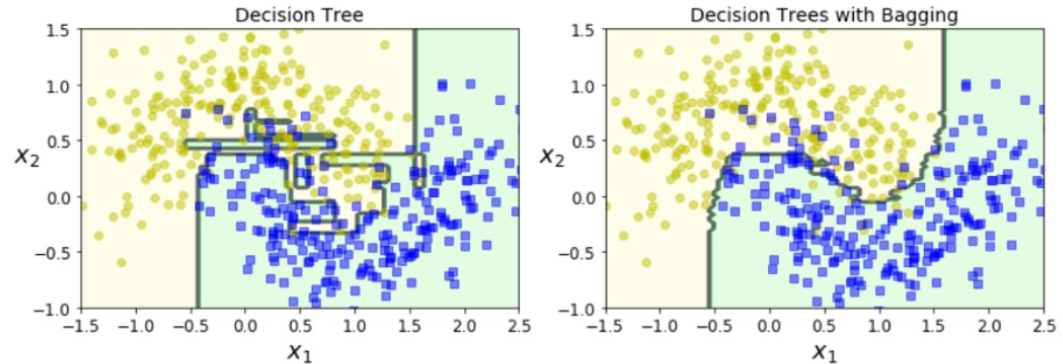

### obb 평가
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 샘플링되고 어떤 것은 전혀 선택되지 않음
- oob(out-of-bag) 샘플
 - 선택되지 않은 훈련 샘플의 나머지 예측
- 앙상블 평가
 - 예측기가 훈련되는 동안 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음
 - 각 예측기의 oob 평가를 평균내어 산출

### 배깅: 훈련 세트에 중복을 허용하여 데이터 샘플링

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


### 페이스팅: 훈련 세트에 중복을 허용하지 않고 데이터 샘플링

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=False, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


### oob 평가

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9253333333333333

In [18]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [19]:
bag_clf.oob_decision_function_

array([[0.33668342, 0.66331658],
       [0.38541667, 0.61458333],
       [1.        , 0.        ],
       [0.01243781, 0.98756219],
       [0.03684211, 0.96315789],
       [0.12467532, 0.87532468],
       [0.393531  , 0.606469  ],
       [0.06756757, 0.93243243],
       [0.92676768, 0.07323232],
       [0.81794195, 0.18205805],
       [0.5575    , 0.4425    ],
       [0.066313  , 0.933687  ],
       [0.75128205, 0.24871795],
       [0.82945736, 0.17054264],
       [0.90339426, 0.09660574],
       [0.08290155, 0.91709845],
       [0.04076087, 0.95923913],
       [0.9258312 , 0.0741688 ],
       [0.66666667, 0.33333333],
       [0.94573643, 0.05426357],
       [0.05154639, 0.94845361],
       [0.24      , 0.76      ],
       [0.89210526, 0.10789474],
       [0.98496241, 0.01503759],
       [0.96640827, 0.03359173],
       [0.00813008, 0.99186992],
       [0.95865633, 0.04134367],
       [0.9973545 , 0.0026455 ],
       [0.02604167, 0.97395833],
       [0.7393617 , 0.2606383 ],
       [0.

# 7.4 랜덤 포레스트
### 랜덤 포레스트
- 배깅 방법(or 페이스팅)을 적용한 결정 트리의 앙상블
- 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중 최적의 특성을 찾는 방식으로 무작위성을 더 부여함
- 편향을 일부 증가시키지만 분산을 낮추어 과대적합의 가능성을 낮춤

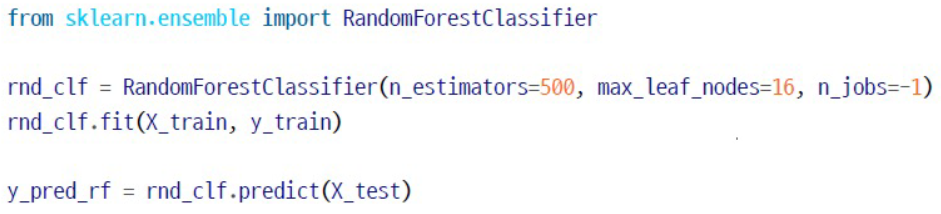

### 특성 중요도(feature importance)
- 특성의 상대적 중요도 측정이 용이함
- 특성의 중요도 측정: 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하는 방식으로 가중치 평균을 계산함

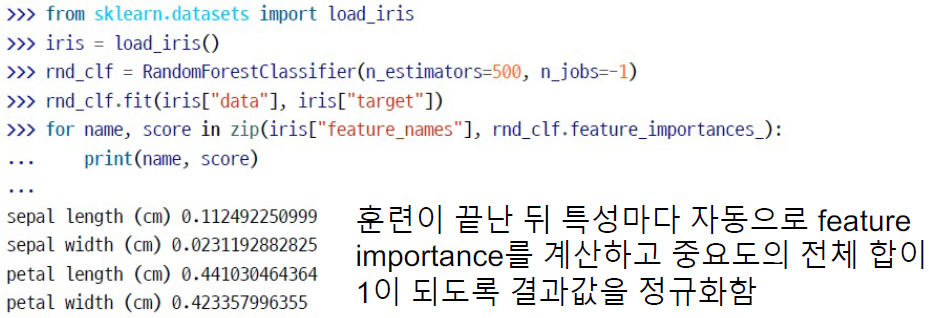

# 7.5 부스팅
### 부스팅(boosting)
- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 에이다부스트 AdaBoost (Adaptive boosting)
- 그래디언트 부스팅 (gradient boosting)

### 에이다부스트 (Adaboost)
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법
 - 이전 모델이 과소적합했던 훈련 샘플의 가중치를 늘림
 - 새로운 예측기가 학습하기 어려운 샘플에 점점 더 맞춰지게 할 수 있음

### 에이다부스트: 200개 결정 트리

In [21]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [42]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# 결정경계 plot 함수

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], iris=False, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("lenth", fontsize=14)
        plt.ylabel("width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

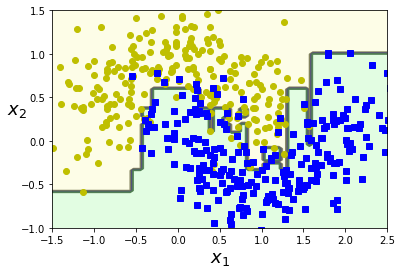

In [43]:
plot_decision_boundary(ada_clf, X, y)